In [1]:
from matplotlib import pyplot
import numpy as np
import time

from caffe2.python import core,workspace
from caffe2.proto import caffe2_pb2

%matplotlib inline

## workspace

In [2]:
print("current blobs in the workspace:{}".format(workspace.Blobs()))

current blobs in the workspace:[]


In [3]:
print("workspace has blob 'X':{}".format(workspace.HasBlob('X')))

workspace has blob 'X':False


In [4]:
X = np.random.randn(2,3).astype(np.float32)
print('Generated X from numpy:\n{}'.format(X))
workspace.FeedBlob('X',X)

Generated X from numpy:
[[ 1.17113626  1.24631178 -0.26786563]
 [ 0.72599679  1.25666177  1.43860745]]


True

In [6]:
print("current blobs in the workspace:{}".format(workspace.Blobs()))
print("workspace has blob 'X':{}".format(workspace.HasBlob('X')))
print("Fetched X:\n{}".format(workspace.FetchBlob('X')))

current blobs in the workspace:[u'X']
workspace has blob 'X':True
Fetched X:
[[ 1.17113626  1.24631178 -0.26786563]
 [ 0.72599679  1.25666177  1.43860745]]


In [7]:
np.testing.assert_array_equal(X, workspace.FetchBlob('X'))

In [8]:
try:
    workspace.FetchBlob('invalid_name')
except RuntimeError as err:
    print(err)

[enforce fail at pybind_state.cc:150] ws->HasBlob(name). Can't find blob: invalid_name 


In [10]:
workspace.CurrentWorkspace()

u'default'

In [11]:
workspace.SwitchWorkspace("gutentag",True)
workspace.CurrentWorkspace()

u'gutentag'

In [12]:
workspace.Blobs()

[]

In [13]:
workspace.SwitchWorkspace("default")
workspace.Blobs()

[u'X']

In [14]:
workspace.ResetWorkspace()
workspace.Blobs()

[]

## Operators

In [15]:
op = core.CreateOperator('Relu',["X"],["Y"])

In [16]:
type(op)

caffe2.proto.caffe2_pb2.OperatorDef

In [18]:
print(str(op))

input: "X"
output: "Y"
name: ""
type: "Relu"



In [20]:
workspace.FeedBlob('X',np.random.randn(2,3).astype(np.float32))
workspace.RunOperatorOnce(op)

True

In [21]:
workspace.Blobs()

[u'X', u'Y']

In [22]:
workspace.FetchBlob('Y')

array([[ 0.        ,  0.        ,  0.12539732],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [23]:
workspace.FetchBlob('X')

array([[-1.78760517, -0.21056654,  0.12539732],
       [-0.9388563 , -0.45075026, -0.2629256 ]], dtype=float32)

In [24]:
op = core.CreateOperator('GaussianFill',[],["Z"],shape=[100,100],mean=1.0,std=1.0)
print(str(op))

output: "Z"
name: ""
type: "GaussianFill"
arg {
  name: "std"
  f: 1.0
}
arg {
  name: "shape"
  ints: 100
  ints: 100
}
arg {
  name: "mean"
  f: 1.0
}



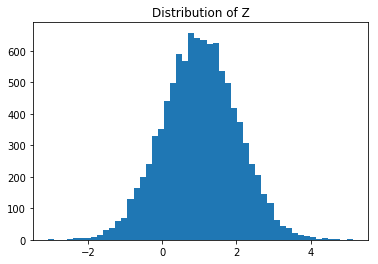

In [26]:
workspace.RunOperatorOnce(op)
temp = workspace.FetchBlob("Z")
pyplot.hist(temp.flatten(), bins=50)
pyplot.title("Distribution of Z")

## Nets

In [27]:
net = core.Net("my_first_net")
print(net.Proto())

name: "my_first_net"



In [28]:
X = net.GaussianFill([],["X"], mean=0.0, std=1.0, shape=[2,3], run_once=0)
print(net.Proto())

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}



In [29]:
type(X)

caffe2.python.core.BlobReference

In [30]:
W = net.GaussianFill([],['W'], mean=0.0, std=1.0, shape=[5,3], run_once=0)
b = net.ConstantFill([],['b'], shape=[5,], value=1.0, run_once=0)

In [31]:
Y = X.FC([W,b],["Y"])

In [32]:
print(net.Proto())

name: "my_first_net"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



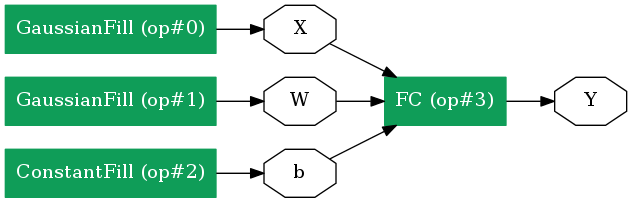

In [33]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(net, rankdir="LR")
display.Image(graph.create_png(), width=800)

In [35]:
workspace.ResetWorkspace()
workspace.RunNetOnce(net)
print(workspace.FetchBlobs(["X","W","b","Y"]))

[array([[ 2.25922728, -0.19354826,  0.48196158],
       [ 1.55991471, -0.57021868,  0.51736099]], dtype=float32), array([[-0.17697838,  0.13829303, -0.84006411],
       [-0.68941927,  0.45068941,  2.02395248],
       [ 0.10685654,  0.05194186,  0.62923634],
       [ 0.99753147, -1.0308665 , -1.08119071],
       [ 0.37230811,  0.38608053,  0.29481685]], dtype=float32), array([ 1.,  1.,  1.,  1.,  1.], dtype=float32), array([[ 0.16852063,  0.33068228,  1.53462768,  2.93208051,  1.90849376],
       [ 0.21045518,  0.71468723,  1.4626112 ,  2.58451748,  1.51314521]], dtype=float32)]


In [36]:
workspace.ResetWorkspace()
workspace.CreateNet(net)
workspace.RunNet(net.Proto().name)

True